In [2]:
import numpy as np 
import scipy
print(np.__version__)
print(scipy.__version__)
import tqdm
import pandas as pd
import exoplanet
import astropy 
import pymc3
import pymc3_ext
import celerite2
from numpy.linalg import inv, det, solve, cond

import matplotlib.pyplot as plt
import matplotlib

1.21.0
1.7.3


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
def partial_mu(t, theta, wrt):
    """
    Unpack parameters and calculate all partial derivatives of the model w.r.t. those parameters
    
    Inputs: 
    - t: time series of length N observations; np.array [day]
    - theta: planet orbital parameters; eg. [K, P, T0]; np.array
    - wrt: parameter with respect to which the model's partial derivative is taken
    
    theta breakdown:
    - K: RV semi-amplitude [cm/s]
    - P: planet period [days]
    - T0: mean transit time [day]
    
    Output:
    - derivative vector of length N
    """

    # unpack parameters
    K, P, T0 = theta[0], theta[1], theta[2]
    
    # calculate partial derivative depending on 'wrt'
    normalized_t = t-T0
    arg = (2*np.pi/P) * normalized_t
    
    if wrt=='K':
        return -np.sin(arg)
    elif wrt=='P':
        return -K * np.cos(arg) * arg/P
    elif wrt=='T0':
        return (2*np.pi*K/P) * np.cos(arg)
    
    print("parameter not recognized")
    
    return                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

def calculate_fim(t, factor2, theta):
    """
    Calculate the generalized Fisher Information Matrix according to I_m,n in 
    https://en.wikipedia.org/wiki/Fisher_information#Multivariate_normal_distribution
    
    Inputs: 
    - t: time series of length N observations; np.array [day]
    - sigma (DEPRECATED): RV measurement uncertainties associated with each observation; np.array of length N [cm/s]; replaced by factor2
    - factor2: inverse covariance matrix; np.array of shape (N, N) [cm/s]
    - theta: planet orbital parameters; eg. [K, P, T0]; np.array
    
    theta breakdown:
    - K: RV semi-amplitude [cm/s]
    - P: planet period [days]
    - T0: mean transit time [day]
    
    Output:
    - Fisher Information Matrix: len(theta)xlen(theta) matrix; np.array
    
    """
    
    fim = np.zeros((len(theta),len(theta)))
    for i in range(len(theta)):
        for j in range(len(theta)):
            wrt_i = param_list[i]
            wrt_j = param_list[j]
            
            factor1 = partial_mu(t, theta, wrt_i)#.reshape((1,4)) # partial derivative of the model wrt row parameter, transposed

            factor3 = partial_mu(t, theta, wrt_j)#.reshape((4,1)) # partial derivative of the model wrt column parameter

            fim[i][j] = factor1 @ factor2 @ factor3 # matrix math magic; thanks to Arvind Gupta for the wisdom
    
    return fim

In [4]:
### priors
param_list = ['K','P','T0']
test_T0 = 2360 # BJD
test_K = 500 # 5 m/s to 500 cm/s; it worked for 10000 cm/s
test_P = 10 # days

test_theta = [test_K, test_P, test_T0]

### free parameters from Langellier et al 2020 for correlated noise
# let's hold these constant for now, but maybe we should sample from the given uncertainties later?
Tau = 23.6 # active region lifetime; days
eta = 0.58 # smoothing parameter
Prot = 28.1 # solar rotation period; days
sigma_qp_s = 1.43e-3 # correlated noise amplitude
sigma_wn_s = 0.178e-3 # white noise amplitude
params = [Tau, eta, Prot, sigma_qp_s, sigma_wn_s]

def make_t(n_obs, cadence, start):
    """
    Gemerate observation times given a number of observations and an average cadence (every X nights)
    
    Input: 
    - n_obs: number of observations to try
    - cadence: amount of time between observations [days]
    - start: start time [BJD]
    
    Output:
    - observation times: ndarray
    
    """
    
    ### make a t using n_obs and cadence
    # initial obs time of 2300 is a placeholder that's set as somewhat close to the arbitrary test_T0 of 2360
    end = start + n_obs * cadence 
    t = np.linspace(2300, end, n_obs, endpoint=False)
    
    # add jitter ~ N(0, 1 hr) to timestamps
    t += np.random.normal(0, 1./24)

    return t

def strategy(start, n_obs, cadence, theta, sigma_val=None):
    """
    Allows user to try different n_obs and cadences and visualize how that affects the expected RV semi-amplitude uncertainty, sigma_K
    
    Input: 
    - start: start time from which I build out n_obs * cadence
    - n_obs: number of observations to try
    - cadence: amount of time between observations [days]
    - theta: planet orbital parameters; eg. [K, P, T0]; np.array
    - sigma_val: RV measurement uncertainties associated with each observation; float64 [cm/s]
    
    theta breakdown:
    - K: RV semi-amplitude [cm/s]
    - P: planet period [days]
    - T0: mean transit time [day]
    
    Output:
    - sigma_ks: array of sigma_k's calculated by np.linalg.inv [cm/s]
    - sigma_ks_stable: array of sigma_k's calculated by 1/np.sqrt(FIM[0][0])
    
    """
    
    ### make a t using n_obs and cadence
    # initial obs time of 2300 is a placeholder that's set as somewhat close to the arbitrary test_T0 of 2360
    t = make_t(n_obs, cadence, start)
    #print("time steps: ", t)
    
    ### make covariance matrix in the scalar, white noise case
    if sigma_val != None:
        sigma_val += 1e-6 # perturb sigma_val to guard against numerical instabilities
        sigma = np.diag(np.ones(len(t))) * sigma_val**2 # covariance matrix of scalar sigma_RV's
        sigma = np.linalg.solve(sigma, np.identity(len(sigma))) # invert to make factor2 for FIM
        
        fim = calculate_fim(t, sigma, theta)
        #print("FIM: ", fim)
        #print("det: ", det(fim))
        inv_fim = inv(fim)
        #print("inv: ", inv_fim)
        sigma_k = np.sqrt(inv_fim)[0][0]
        #print("sigma_K, using inv: ", sigma_k)
        #sigma_ks.append(sigma_k)
        sigma_k_stable = np.sqrt(1/fim[0][0])
        #print("sigma_K, not using inv: ", sigma_k_stable)

        # np.linalg.solve is more stable than np.linalg.inv, apparently
        inv_fim_solve = solve(fim, np.diag(np.ones(len(theta)))) 
        sigma_k_solve = np.sqrt(inv_fim_solve)[0][0]
        
        return sigma_k, sigma_k_stable, sigma_k_solve, fim
    
    ### make covariance matrix in the correlated noise case
    else:
        sigma = cov_matrix(t, params)
        sigma += 1e-6 
        
        fim = calculate_fim(t, sigma, theta)
        inv_fim = inv(fim)
        sigma_k = np.sqrt(inv_fim)[0][0]
    
        return sigma_k, fim

print(strategy(start=2352, n_obs=100, cadence=1, theta=test_theta, sigma_val=30)) # default to 2300


(4.266750363598533, 4.266649679522261, 4.266750363598533, array([[ 5.49320780e-02, -3.90079805e-01, -5.45911735e-02],
       [-3.90079805e-01,  1.22091431e+05, -8.47833188e+03],
       [-5.45911735e-02, -8.47833188e+03,  5.54464759e+03]]))


In [5]:
def model(t, theta): 
    """
    Radial velocity model, given timestamps and planetary orbital parameters
    
    Inputs: 
    - t: time series of length N observations; np.array [day]
    - sigma: RV measurement uncertainties associated with each observation; np.array of length N [cm/s]
    - theta: planet orbital parameters; eg. [K, P, T0]; np.array
    
    theta breakdown:
    - K: RV semi-amplitude [cm/s]
    - P: planet period [days]
    - T0: mean transit time [day]

    """
    
    K, P, T0 = theta[0], theta[1], theta[2]
    arg = (2*np.pi/P)*(t-T0)
    rv = -K * np.sin(arg)
    
    return rv

In [6]:
# arbitrary row, yellow streak column
cadence = 3.6
n_obs = 13

print(strategy(start=2300, n_obs=n_obs, cadence=cadence, theta=test_theta, sigma_val=30)) # default to 2300



(12.100431283545074, 12.050716919057331, 12.100431283545074, array([[6.88611436e-03, 5.41140413e-01, 1.75664083e-01],
       [5.41140413e-01, 1.29439165e+04, 2.92751754e+03],
       [1.75664083e-01, 2.92751754e+03, 7.45977184e+02]]))


/tmp/ipykernel_512570/504008953.py:80: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]
/tmp/ipykernel_512570/504008953.py:88: RuntimeWarning: invalid value encountered in sqrt
  sigma_k_solve = np.sqrt(inv_fim_solve)[0][0]


/tmp/ipykernel_512570/504008953.py:80: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]
/tmp/ipykernel_512570/504008953.py:88: RuntimeWarning: invalid value encountered in sqrt
  sigma_k_solve = np.sqrt(inv_fim_solve)[0][0]


FIM:  [[6.91208527e-03 5.69827970e-01 1.80317330e-01]
 [5.69827970e-01 1.29285915e+04 2.92223414e+03]
 [1.80317330e-01 2.92223414e+03 7.43413957e+02]]
sigma_k using linalg.inv:  12.078075151619561
sigma_k using linalg.solve:  12.078075151619561
sigma_k using 1/sqrt(FIM_ii):  12.028056415669719


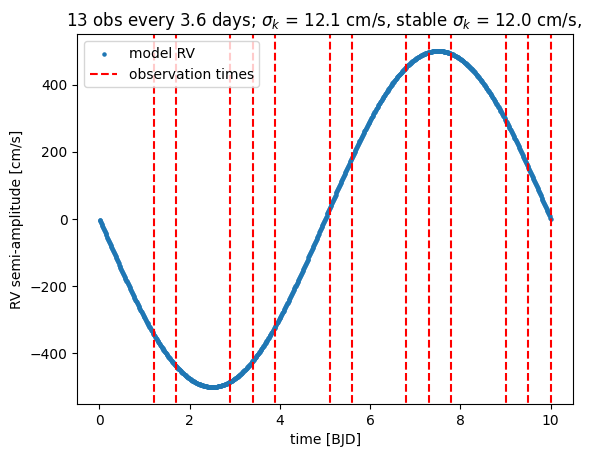

In [7]:
### strategy
cadence = 3.6
n_obs = 13

sigma_k, sigma_k_stable, sigma_k_solve, fim = strategy(start=2300, n_obs=n_obs, cadence=cadence, theta=test_theta, sigma_val=30)
print("FIM: ", fim)
print("sigma_k using linalg.inv: ", sigma_k)
print("sigma_k using linalg.solve: ", sigma_k_solve)
print("sigma_k using 1/sqrt(FIM_ii): ", sigma_k_stable)
      
### RV model
start = 2300 # BJD
end = 2400 # BJD
test_t = np.linspace(start, end, 1000) + np.random.normal(0, 1./24)
test_t_phase_folded = test_t % test_P
sigma_val = 30+1e-6 # cm/s
test_sigma = np.ones(len(test_t))*sigma_val
y = model(test_t, test_theta)
y_phase_folded = model(test_t_phase_folded, test_theta)

### plot observations from strategy
end = start + cadence * n_obs
strat = np.linspace(2300, end, n_obs) + np.random.normal(0, 1./24)
strat_phase_folded = strat % test_P

plt.scatter(test_t_phase_folded, y_phase_folded, s=5, label='model RV')
plt.axvline(0, 0, 0, linestyle='--', c='r', label='observation times')
for i in strat_phase_folded:
    plt.axvline(i, min(y_phase_folded), max(y_phase_folded), linestyle='--', c='r')
plt.xlabel('time [BJD]')
plt.ylabel('RV semi-amplitude [cm/s]')
plt.title(f'{n_obs} obs every {cadence} days; ' + r'${\sigma}_k$' + f' = {np.round(sigma_k, 1)} cm/s, ' + r'stable ${\sigma}_k$' + f' = {np.round(sigma_k_stable, 1)} cm/s, ')
plt.savefig('plots/strategy1.pdf', format='pdf')
plt.legend()
plt.show()

/tmp/ipykernel_1168392/2571712685.py:71: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]
/tmp/ipykernel_1168392/2571712685.py:79: RuntimeWarning: invalid value encountered in sqrt
  sigma_k_solve = np.sqrt(inv_fim_solve)[0][0]


FIM:  [[ 3.94402249e-02 -6.05457794e-01  2.21063802e-03]
 [-6.05457794e-01  4.35837068e+04  1.61054459e+03]
 [ 2.21063802e-03  1.61054459e+03  3.89342656e+03]]
sigma_k using linalg.inv:  5.03590455125487
sigma_k using linalg.solve:  5.03590455125487
sigma_k using 1/sqrt(FIM_ii):  5.035357485410611


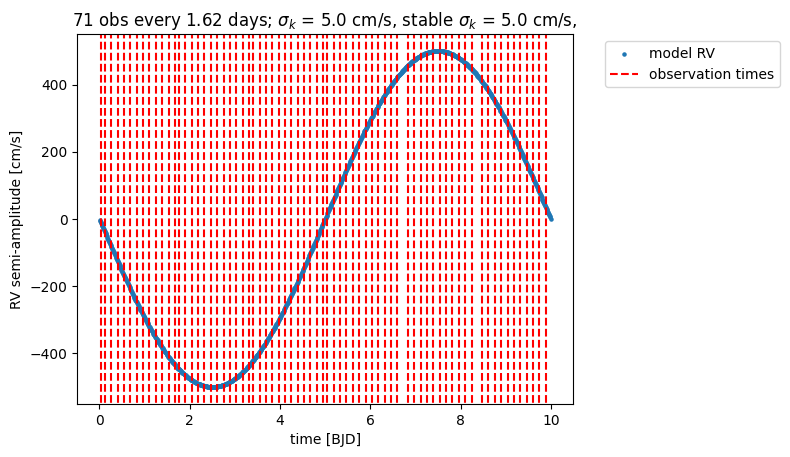

In [68]:
### strategy
cadence = 1.62
n_obs = 71

sigma_k, sigma_k_stable, sigma_k_solve, fim = strategy(start=2300, n_obs=n_obs, cadence=cadence, theta=test_theta, sigma_val=30)
print("FIM: ", fim)
print("sigma_k using linalg.inv: ", sigma_k)
print("sigma_k using linalg.solve: ", sigma_k_solve)
print("sigma_k using 1/sqrt(FIM_ii): ", sigma_k_stable)
      
### RV model
start = 2300 # BJD
end = 2400 # BJD
test_t = np.linspace(start, end, 1000) + np.random.normal(0, 1./24)
test_t_phase_folded = test_t % test_P
sigma_val = 30+1e-6 # cm/s
test_sigma = np.ones(len(test_t))*sigma_val
y = model(test_t, test_theta)
y_phase_folded = model(test_t_phase_folded, test_theta)

### plot observations from strategy
end = start + cadence * n_obs
strat = np.linspace(2300, end, n_obs) + np.random.normal(0, 1./24)
strat_phase_folded = strat % test_P

plt.scatter(test_t_phase_folded, y_phase_folded, s=5, label='model RV')
plt.axvline(0, 0, 0, linestyle='--', c='r', label='observation times')
for i in strat_phase_folded:
    plt.axvline(i, min(y_phase_folded), max(y_phase_folded), linestyle='--', c='r')
plt.xlabel('time [BJD]')
plt.ylabel('RV semi-amplitude [cm/s]')
plt.title(f'{n_obs} obs every {cadence} days; ' + r'${\sigma}_k$' + f' = {np.round(sigma_k, 1)} cm/s, ' + r'stable ${\sigma}_k$' + f' = {np.round(sigma_k_stable, 1)} cm/s, ')
plt.savefig('plots/strategy2.pdf', format='pdf')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

/tmp/ipykernel_1168392/2571712685.py:71: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]
/tmp/ipykernel_1168392/2571712685.py:79: RuntimeWarning: invalid value encountered in sqrt
  sigma_k_solve = np.sqrt(inv_fim_solve)[0][0]


FIM:  [[ 4.02791689e-02  2.43669278e-01 -1.60123665e-01]
 [ 2.43669278e-01  4.77461480e+04  8.19524666e+02]
 [-1.60123665e-01  8.19524666e+02  4.02995064e+03]]
sigma_k using linalg.inv:  4.983135528251253
sigma_k using linalg.solve:  4.983135528251253
sigma_k using 1/sqrt(FIM_ii):  4.982642748784209


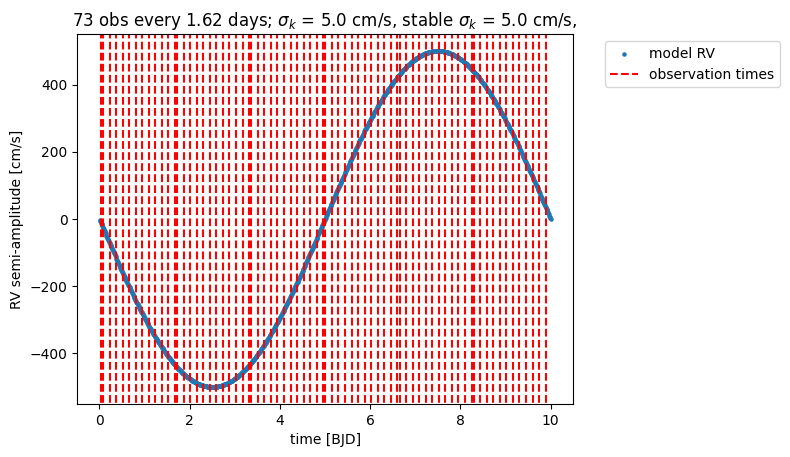

In [69]:
### strategy
cadence = 1.62
n_obs = 73

sigma_k, sigma_k_stable, sigma_k_solve, fim = strategy(start=2300, n_obs=n_obs, cadence=cadence, theta=test_theta, sigma_val=30)
print("FIM: ", fim)
print("sigma_k using linalg.inv: ", sigma_k)
print("sigma_k using linalg.solve: ", sigma_k_solve)
print("sigma_k using 1/sqrt(FIM_ii): ", sigma_k_stable)
      
### RV model
start = 2300 # BJD
end = 2400 # BJD
test_t = np.linspace(start, end, 1000) + np.random.normal(0, 1./24)
test_t_phase_folded = test_t % test_P
sigma_val = 30+1e-6 # cm/s
test_sigma = np.ones(len(test_t))*sigma_val
y = model(test_t, test_theta)
y_phase_folded = model(test_t_phase_folded, test_theta)

### plot observations from strategy
end = start + cadence * n_obs
strat = np.linspace(2300, end, n_obs) + np.random.normal(0, 1./24)
strat_phase_folded = strat % test_P

plt.scatter(test_t_phase_folded, y_phase_folded, s=5, label='model RV')
plt.axvline(0, 0, 0, linestyle='--', c='r', label='observation times')
for i in strat_phase_folded:
    plt.axvline(i, min(y_phase_folded), max(y_phase_folded), linestyle='--', c='r')
plt.xlabel('time [BJD]')
plt.ylabel('RV semi-amplitude [cm/s]')
plt.title(f'{n_obs} obs every {cadence} days; ' + r'${\sigma}_k$' + f' = {np.round(sigma_k, 1)} cm/s, ' + r'stable ${\sigma}_k$' + f' = {np.round(sigma_k_stable, 1)} cm/s, ')
plt.savefig('plots/strategy3.pdf', format='pdf')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

/tmp/ipykernel_1168392/2571712685.py:71: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]
/tmp/ipykernel_1168392/2571712685.py:79: RuntimeWarning: invalid value encountered in sqrt
  sigma_k_solve = np.sqrt(inv_fim_solve)[0][0]


FIM:  [[ 3.96830620e-02  6.96634600e+01  4.37990565e-03]
 [ 6.96634600e+01  1.27776800e+06 -4.83879825e+04]
 [ 4.37990565e-03 -4.83879825e+04  4.08878403e+03]]
sigma_k using linalg.inv:  5.522385590687375
sigma_k using linalg.solve:  5.522385590687375
sigma_k using 1/sqrt(FIM_ii):  5.019927122421496


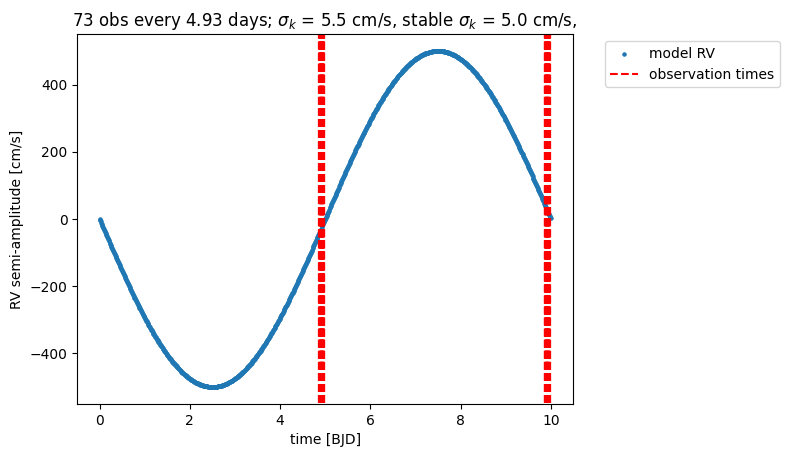

In [72]:
### strategy
cadence = 4.93
n_obs = 73

sigma_k, sigma_k_stable, sigma_k_solve, fim = strategy(start=2300, n_obs=n_obs, cadence=cadence, theta=test_theta, sigma_val=30)
print("FIM: ", fim)
print("sigma_k using linalg.inv: ", sigma_k)
print("sigma_k using linalg.solve: ", sigma_k_solve)
print("sigma_k using 1/sqrt(FIM_ii): ", sigma_k_stable)
      
### RV model
start = 2300 # BJD
end = 2400 # BJD
test_t = np.linspace(start, end, 1000) + np.random.normal(0, 1./24)
test_t_phase_folded = test_t % test_P
sigma_val = 30+1e-6 # cm/s
test_sigma = np.ones(len(test_t))*sigma_val
y = model(test_t, test_theta)
y_phase_folded = model(test_t_phase_folded, test_theta)

### plot observations from strategy
end = start + cadence * n_obs
strat = np.linspace(2300, end, n_obs) + np.random.normal(0, 1./24)
strat_phase_folded = strat % test_P

plt.scatter(test_t_phase_folded, y_phase_folded, s=5, label='model RV')
plt.axvline(0, 0, 0, linestyle='--', c='r', label='observation times')
for i in strat_phase_folded:
    plt.axvline(i, min(y_phase_folded), max(y_phase_folded), linestyle='--', c='r')
plt.xlabel('time [BJD]')
plt.ylabel('RV semi-amplitude [cm/s]')
plt.title(f'{n_obs} obs every {cadence} days; ' + r'${\sigma}_k$' + f' = {np.round(sigma_k, 1)} cm/s, ' + r'stable ${\sigma}_k$' + f' = {np.round(sigma_k_stable, 1)} cm/s, ')
plt.savefig('plots/strategy4.pdf', format='pdf')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

In [11]:
def cov_matrix(t, params):
    """
    Build a covariance matrix, Sigma, that will be used in the calculation of the Fisher Information Matrix
    
    Inputs:
    - t: time series of length N observations; np.array [day]
    - Tau: active region lifetime [days]; free param taken from Langellier et al 2020
    - eta: smoothing parameter; free param taken from Langellier et al 2020
    - Prot: rotation period [days]; free param taken from Langellier et al 2020
    - sigma_qp_s: correlated noise amplitude; free param taken from Langellier et al 2020
    - sigma_wn_s: white noise amplitude; free param taken from Langellier et al 2020
    
    Outputs:
    - N by N matrix of covariance elements following Equations 1 & 2 of Langellier et al 2020
    
    """
    
    Tau, eta, Prot, sigma_qp_s, sigma_wn_s = params[0], params[1], params[2], params[3], params[4]
    
    # create N by N matrix, where N is length of observations time series
    k = np.zeros((len(t),len(t)))
    
    for i in range(len(t)):
        for j in range(len(t)):
            term1 = ((t[i]-t[j])**2)/(2*Tau**2)
            term2 = (1/(2*eta**2)) * (np.sin(np.pi * (t[i] - t[j])/Prot))**2
            arg = -term1 - term2
            k[i][j] = np.exp(arg)
    
    K = sigma_qp_s**2 * k + sigma_wn_s**2 * np.diag(np.ones(len(t)))
    
    return K

dim = 100
n_observations = np.linspace(3, 102, dim).astype(int)
cadence = 3 # 4.97 # 1.62

sigma_k_test = []
sigma_k_solve_test = []
sigma_k_stable_test = []
fi_k_test = []
for n_obs in n_observations:
    t = make_t(n_obs, cadence, start)
    sigma_val += 1e-6 # perturb sigma_val to guard against numerical instabilities
    sigma = np.diag(np.ones(len(t))) * sigma_val**2 # covariance matrix of scalar sigma_RV's
    sigma = np.linalg.solve(sigma, np.identity(len(sigma))) # invert to make factor2 for FIM
    
    fim = calculate_fim(t, sigma, test_theta)
    fi_k = fim[0][0]
    inv_fim = inv(fim)
    sigma_k = np.sqrt(inv_fim)[0][0]
    sigma_k_stable = np.sqrt(1/fim[0][0])
    inv_fim_solve = solve(fim, np.diag(np.ones(len(test_theta)))) 
    sigma_k_solve = np.sqrt(inv_fim_solve)[0][0]
    
    sigma_k_test.append(sigma_k)
    sigma_k_solve_test.append(sigma_k_solve)
    sigma_k_stable_test.append(sigma_k_stable)
    
    fi_k_test.append(fi_k)

/tmp/ipykernel_512570/2779582372.py:51: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]
/tmp/ipykernel_512570/2779582372.py:54: RuntimeWarning: invalid value encountered in sqrt
  sigma_k_solve = np.sqrt(inv_fim_solve)[0][0]


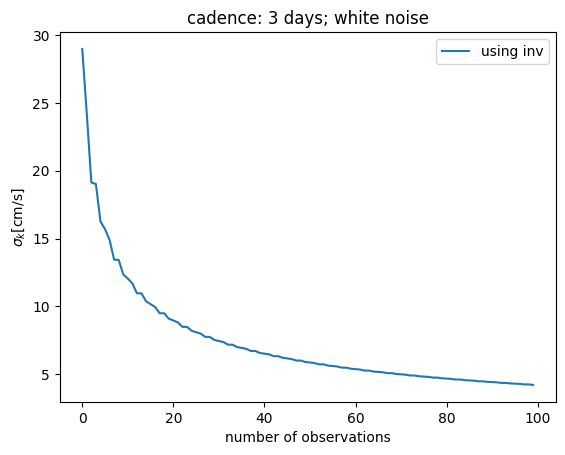

In [9]:
plt.plot(range(len(sigma_k_test)), sigma_k_test, label='using inv')
#plt.plot(range(len(sigma_k_stable_test)), sigma_k_stable_test, label='not using inv')
plt.xlabel('number of observations')
plt.ylabel(r"$\sigma_k$[cm/s]")
plt.title(f"cadence: {cadence} days; white noise")
plt.legend()
plt.show()

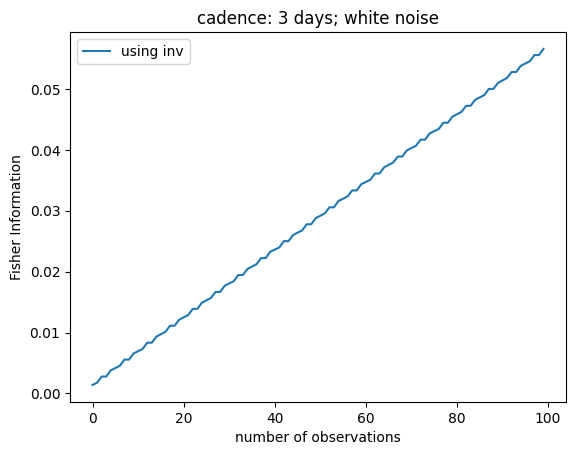

In [12]:
plt.plot(range(len(fi_k_test)), fi_k_test, label='using inv')
#plt.plot(range(len(sigma_k_stable_test)), sigma_k_stable_test, label='not using inv')
plt.xlabel('number of observations')
plt.ylabel("Fisher Information")
plt.title(f"cadence: {cadence} days; white noise")
plt.legend()
plt.show()

Let's explore the full parameter space of (n_obs, cadence), so that we can plot sensitivity maps

In [42]:
# priors
param_list = ['K','P','T0']
test_T0 = 2360 # BJD
test_K = 500 # 5 m/s to 500 cm/s; it worked for 10000 cm/s
test_P = 10 # days
test_theta = [test_K, test_P, test_T0]

dim = 100

### try different numbers of total observations made
n_observations = np.linspace(3, 102, dim).astype(int)

### try different observing cadences
### lower bound
# Arjun Savel (thanks, Arjun!) says that 0.6 days is generally considered the minimum (why?)
# Nyquist sampling says halve that to 0.3 days
# Nyquist sampling says the minimum number of observations you need to confirm periodicity is 2
# See wikipedia page for 'Nyquist rate'

### upper bound
# TESS planets generally have max period of 13.7 days
# again, due to Nyquist, halve it to 6.85 days
cadences = np.linspace(0.30, 6.85, dim)
sigma_ks = np.ones(dim**2).reshape((dim,dim))
sigma_ks_stable = np.ones(dim**2).reshape((dim,dim))
sigma_ks_solve = np.ones(dim**2).reshape((dim,dim))

#with tqdm.tqdm(total=100) as pbar:
for enum_i, i in enumerate(n_observations):
    for enum_j, j in enumerate(cadences):
        #print(i, j)
        sigma_k, sigma_k_stable, sigma_k_solve, fim = strategy(start=2300, n_obs=i, cadence=j, theta=test_theta, sigma_val=30)

        sigma_ks[enum_i][enum_j] = sigma_k
        sigma_ks_stable[enum_i][enum_j] = sigma_k_stable
        sigma_ks_solve[enum_i][enum_j] = sigma_k_solve

/tmp/ipykernel_1168392/2571712685.py:71: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]
/tmp/ipykernel_1168392/2571712685.py:79: RuntimeWarning: invalid value encountered in sqrt
  sigma_k_solve = np.sqrt(inv_fim_solve)[0][0]


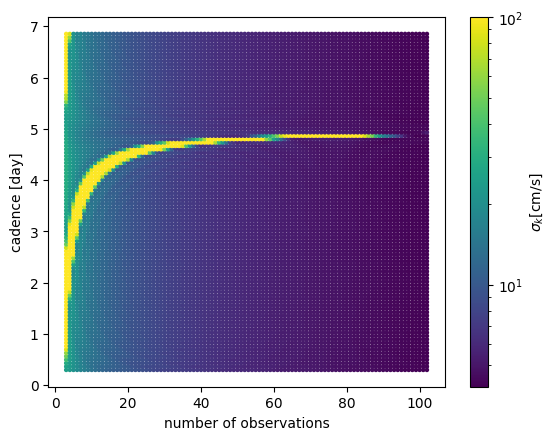

In [64]:
x, y = np.meshgrid(n_observations, cadences)
plt.scatter(x, y, c=sigma_ks.T, s=5, norm=matplotlib.colors.LogNorm(vmax=1e2))
cbar = plt.colorbar()
cbar.ax.set_ylabel(r"$\sigma_k$[cm/s]")
plt.xlabel("number of observations")
plt.ylabel("cadence [day]")
#plt.savefig("plots/n_obs-cadence-sigma_k-white.pdf", format="pdf")
plt.show()

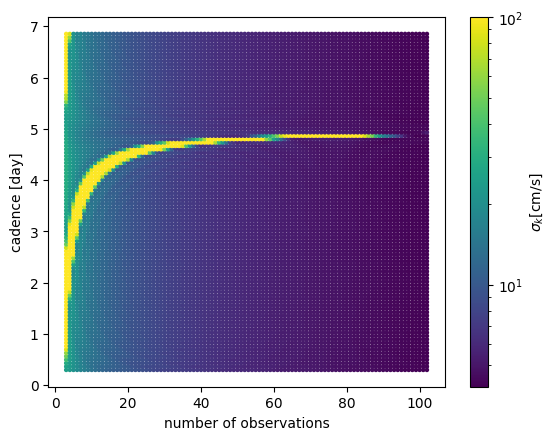

In [65]:
x, y = np.meshgrid(n_observations, cadences)
plt.scatter(x, y, c=sigma_ks_solve.T, s=5, norm=matplotlib.colors.LogNorm(vmax=1e2))
cbar = plt.colorbar()
cbar.ax.set_ylabel(r"$\sigma_k$[cm/s]")
plt.xlabel("number of observations")
plt.ylabel("cadence [day]")
#plt.savefig("plots/n_obs-cadence-sigma_k-solve-white.pdf", format="pdf")
plt.show()

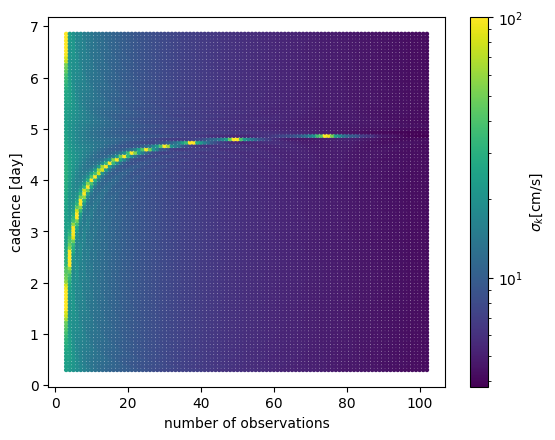

In [61]:
x, y = np.meshgrid(n_observations, cadences)
plt.scatter(x, y, c=sigma_ks_stable.T, s=5, norm=matplotlib.colors.LogNorm(vmax=1e2))
cbar = plt.colorbar()
cbar.ax.set_ylabel(r"$\sigma_k$[cm/s]")
plt.xlabel("number of observations")
plt.ylabel("cadence [day]")
#plt.savefig("plots/n_obs-cadence-sigma_k-stable-white.pdf", format="pdf")
plt.show()

Let's marginalize over different starts time to get a more smoothed picture

In [52]:
# priors
param_list = ['K','P','T0']
test_T0 = 2360 # BJD
test_K = 500 # 5 m/s to 500 cm/s; it worked for 10000 cm/s
test_P = 10 # days
test_theta = [test_K, test_P, test_T0]

dim = 100

### try different numbers of total observations made
n_observations = np.linspace(3, 102, dim).astype(int)

### try different observing cadences
### lower bound
# Arjun Savel (thanks, Arjun!) says that 0.6 days is generally considered the minimum (why?)
# Nyquist sampling says halve that to 0.3 days
# Nyquist sampling says the minimum number of observations you need to confirm periodicity is 2
# See wikipedia page for 'Nyquist rate'

### upper bound
# TESS planets generally have max period of 13.7 days
# again, due to Nyquist, halve it to 6.85 days
cadences = np.linspace(0.30, 6.85, dim)

#with tqdm.tqdm(total=100) as pbar:
starts = np.linspace(2300, 2300+test_P, 200)
sigma_ks_all = np.ones(dim**2).reshape((dim,dim))
sigma_ks_stable_all = np.ones(dim**2).reshape((dim,dim))
sigma_ks_solve_all = np.ones(dim**2).reshape((dim,dim))
    
for start in starts: 
    sigma_ks = np.ones(dim**2).reshape((dim,dim))
    sigma_ks_stable = np.ones(dim**2).reshape((dim,dim))
    sigma_ks_solve = np.ones(dim**2).reshape((dim,dim))

    for enum_i, i in enumerate(n_observations):
        for enum_j, j in enumerate(cadences):
            try:
                sigma_k, sigma_k_stable, sigma_k_solve, fim = strategy(start=start, n_obs=i, cadence=j, theta=test_theta, sigma_val=30)
            except Exception as e:
                print(e, ", culprit: ", start, i, j)

            sigma_ks[enum_i][enum_j] = sigma_k
            sigma_ks_stable[enum_i][enum_j] = sigma_k_stable
            sigma_ks_solve[enum_i][enum_j] = sigma_k_solve

            sigma_ks_all += sigma_ks
            sigma_ks_stable_all += sigma_ks_stable
            sigma_ks_solve_all += sigma_ks_solve

/tmp/ipykernel_1168392/2571712685.py:71: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]
/tmp/ipykernel_1168392/2571712685.py:79: RuntimeWarning: invalid value encountered in sqrt
  sigma_k_solve = np.sqrt(inv_fim_solve)[0][0]


Singular matrix , culprit:  2300.603015075377 3 4.798989898989898
Singular matrix , culprit:  2300.8040201005024 4 4.798989898989898
Singular matrix , culprit:  2301.809045226131 9 4.798989898989898
Singular matrix , culprit:  2302.0100502512564 10 4.798989898989898
Singular matrix , culprit:  2302.211055276382 11 4.798989898989898
Singular matrix , culprit:  2302.5628140703516 19 4.865151515151514
Singular matrix , culprit:  2302.814070351759 14 4.798989898989898
Singular matrix , culprit:  2303.618090452261 18 4.798989898989898
Singular matrix , culprit:  2304.0201005025124 20 4.798989898989898
Singular matrix , culprit:  2304.6231155778896 23 4.798989898989898
Singular matrix , culprit:  2304.974874371859 5 4.005050505050505
Singular matrix , culprit:  2305.175879396985 6 4.137373737373737
Singular matrix , culprit:  2306.834170854271 34 4.798989898989898
Singular matrix , culprit:  2306.9849246231156 15 4.534343434343434
Singular matrix , culprit:  2307.035175879397 35 4.7989898989

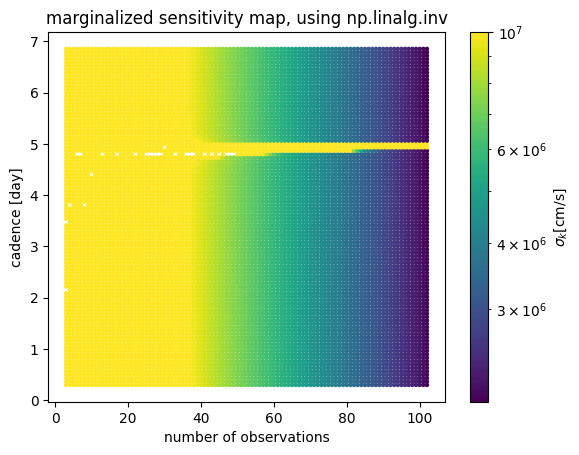

In [59]:
x, y = np.meshgrid(n_observations, cadences)
plt.scatter(x, y, c=sigma_ks_all.T, s=5, norm=matplotlib.colors.LogNorm(vmax=1e7))
cbar = plt.colorbar()
cbar.ax.set_ylabel(r"$\sigma_k$[cm/s]")
plt.title("marginalized sensitivity map, using np.linalg.inv")
plt.xlabel("number of observations")
plt.ylabel("cadence [day]")
plt.show()

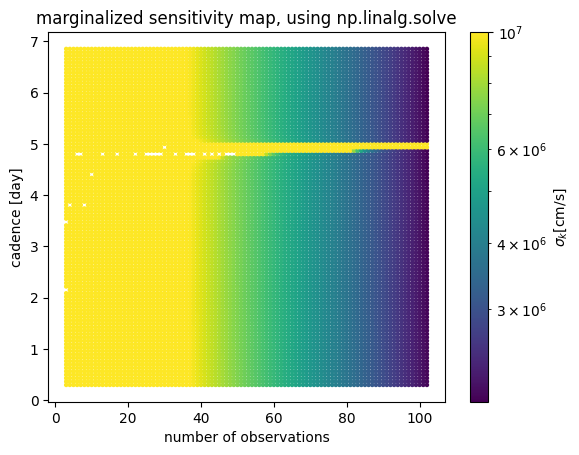

In [56]:
x, y = np.meshgrid(n_observations, cadences)
plt.scatter(x, y, c=sigma_ks_solve_all.T, s=5, norm=matplotlib.colors.LogNorm(vmax=1e7))
cbar = plt.colorbar()
cbar.ax.set_ylabel(r"$\sigma_k$[cm/s]")
plt.title("marginalized sensitivity map, using np.linalg.solve")
plt.xlabel("number of observations")
plt.ylabel("cadence [day]")
plt.show()

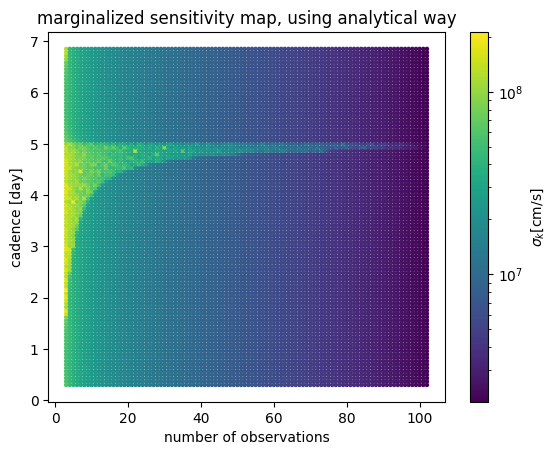

In [55]:
x, y = np.meshgrid(n_observations, cadences)
plt.scatter(x, y, c=sigma_ks_stable_all.T, s=5, norm=matplotlib.colors.LogNorm())
cbar = plt.colorbar()
cbar.ax.set_ylabel(r"$\sigma_k$[cm/s]")
plt.title("marginalized sensitivity map, using analytical way")
plt.xlabel("number of observations")
plt.ylabel("cadence [day]")
plt.show()